## `Материалы кафедры ММП факультета ВМК МГУ. Введение в эффективные системы глубокого обучения.`

## `Задание 03. Ускорение inference BERT`

#### Фамилия, имя:

Дата выдачи: <span style="color:red">__14.10.2025 2:30__</span>.

Мягкий дедлайн: <span style="color:red">__28.10.2025 1:30__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __3.1 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

По всем вопросам по заданию писать Оганову Александру (tg: @welmud).

Задание вдохновлено домашним заданием с курса [Глубинное обучение для текстовых данных](https://github.com/ashaba1in/hse-nlp/blob/05f0c8a06d58b2023705bf5d147ddcfc13b4eb03/week7_size_reduction/homework/hw4.ipynb), ФКН ВШЭ.


## `Постановка задачи`

Основная цель этого задания ускорить модель BERT для более эффективного inference. Мы будем рассматривать следующие подходы:
- Дистилляция;
- Квантизация;
- Прунинг.

Для корректной валидации методов ускорения, мы будем тестировать подходы на хорошо знакомой вам задаче Named Entity Recognition (NER) на самом популярном датасете – [CoNLL-2003](https://paperswithcode.com/dataset/conll-2003). Мы уже предобучили модель BERT, поэтома ваша цель **ускорить исходную модель с минимальной потерей качества**.


### `Очередное напоминание о NER`

Named Entity Recognition – это задача классификации токенов по классам сущностей. В CoNLL-2003 для именования сущностей используется маркировка **BIO** (Beggining, Inside, Outside), в которой метки означают следующее:

- *B-{метка}* – начало сущности *{метка}*
- *I-{метка}* – продолжение сущности *{метка}*
- *O* – не сущность

Всего в датасете есть 9 разных меток.
- O – слову не соответствует ни одна сущность.
- B-PER/I-PER – слово или набор слов соответствует определенному _человеку_.
- B-ORG/I-ORG – слово или набор слов соответствует определенной _организации_.
- B-LOC/I-LOC – слово или набор слов соответствует определенной _локации_.
- B-MISC/I-MISC – слово или набор слов соответствует сущности, которая не относится ни к одной из предыдущих. Например, национальность, произведение искусства, мероприятие и т.д.


### `Технические детали`

В задании будет необходимо поставить много экспериментов, некоторые из них требуют обучения новой модели, другие нет. В основном мы будем работать с библиотекой hugging face. Мы тестировали код на `Python 3.12.11` и следующими версиями библиотек:

```
- torch==2.6.0
- torchaudio==2.6.0
- torchvision==0.21.0
- transformers==4.56.1
- datasets==3.6.0
- tqdm==4.67.1
- comet_ml==3.51.0
- seqeval==1.2.2
- accelerate-1.10.1
- triton==2.3.0
```


**Примечание**.
Вы можете выполнять задание параллельно, пока считаются эксперименты из первой части задания, вы можете решать остальные части задания. В случае вопросов и технических проблем следует писать в чат, задание новое.

In [1]:
!nvidia-smi

Mon Oct 13 21:45:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Этот код может вам помочь установить нужные библиотеки. Лучше использовать Google Colab.

# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 # Можете использовать --index-url https://download.pytorch.org/whl/cu124 если считаете нужным
# !pip install triton==3.2.0
# !pip install datasets==3.6.0
# !pip install seqeval==1.2.2

In [3]:
!pip freeze | grep datasets
!pip freeze | grep triton

datasets==3.6.0
tensorflow-datasets==4.9.9
vega-datasets==0.9.0
triton==3.2.0


# `Часть 0. Загрузка и предобработка данных (1 балл)`

In [4]:
import time
import random
from copy import deepcopy
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn.utils.prune as prune

from datasets import load_dataset
from seqeval.metrics import f1_score

from transformers import AutoModelForTokenClassification
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DataCollatorForTokenClassification


Важной частью задания является постановка экспериментов связанных с обучением, поэтому важно фиксировать все генераторы случайных чисел для воспроизводимости. Нет смысла сравнивать результаты, если модели начинали учиться с разных инициализаций. Код ниже позволяет достаточно точно гарантировать воспроизводимость результатов.

In [5]:
def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Настроем device, так как мы будем работать с BERT, то есть, трансформером, то крайне рекомендуется работа на GPU.

In [6]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
device

'cuda'

Рекомендуемые гиперпараметры представлены ниже. Мы не требуем логирования в какой-либо конкретный логер, поэтому вы можете сами указать поле `report_to` на любой удобный для вас или оставить `none`. Подробнее можно почитать [в документации](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.report_to).

In [7]:
base_config = {
    'eval_strategy': "epoch",
    'save_strategy': "epoch",
    'learning_rate': 2e-5,
    'num_train_epochs': 15,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'push_to_hub': False,
    'report_to': "none"
}

Загрузим датасет и удалим не нужные столбцы: `id`, `pos_tags`, `chunk_tags`.  

In [8]:
dataset = load_dataset("eriktks/conll2003")

dataset = dataset.remove_columns(["id", "pos_tags", "chunk_tags"])
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

Создадим отображения меток тегов в номера классов и наоборот.

In [9]:
label_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

Посмотрим на пример из датасета.

In [10]:
words = dataset["train"][0]["tokens"]
labels = dataset["train"][0]["ner_tags"]

for i in range(len(words)):
    print(f'{words[i]}\t{label_names[labels[i]]}')

EU	B-ORG
rejects	O
German	B-MISC
call	O
to	O
boycott	O
British	B-MISC
lamb	O
.	O


### `Получение tokenizer-independent представления`

На протяжении всего домашнего задания мы будем использовать _cased_ версию BERT, то есть токенизатор будет учитывать регистр слов. Для задачи NER регистр важен, так как имена и названия организаций или предметов искусства часто пишутся с большой буквы, и будет глупо прятать от модели такую информацию.

In [11]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

**Задание 0 (0.5 баллов)**. Токенизируйте весь датасет и для каждого текста выравните токены с метками так, чтобы каждому токену соответствовала одна метка. При этом важно сохранить нотацию BIO. И не забудьте про специальные токены!


**Подсказка**. Вы можете взять свой код из задания 3.5 курса `Введение в глубокое обучение` или воспользоваться официальным [туториалом](https://huggingface.co/learn/llm-course/chapter7/2). В качестве специального токена используйте -100.

In [12]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            # YOUR CODE HERE
            label = ...
            new_labels.append(label)
        elif word_id is None:
            # Special token
            # YOUR CODE HERE
            label = ...
            new_labels.append(label)
        else:
            # Same word as previous token
            # YOUR CODE HERE
            label = ...
            # If the label is B-XXX we change it to I-XXX
            # YOUR CODE HERE
            ...

            new_labels.append(label)

    return new_labels

Должно получится что-то такое:

In [13]:
example = dataset["train"][12]
tags = [label_names[t] for t in example["ner_tags"]]
tokenized_text = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)

aligned_labels = align_labels_with_tokens(example["ner_tags"], tokenized_text.word_ids())
tags = [label_names[t] if t > -1 else t for t in aligned_labels]
print("Выровненные метки:", aligned_labels)
print("Выровненные названия меток:", tags)

Выровненные метки: [-100, 0, 5, 0, 5, 0, 1, 2, 2, 0, 0, 0, 0, -100]
Выровненные названия меток: [-100, 'O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', -100]


In [14]:
assert aligned_labels == [-100, 0, 5, 0, 5, 0, 1, 2, 2, 0, 0, 0, 0, -100], f"{aligned_labels}"
assert tags == [-100, 'O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', -100], f"{tags}"

#### **Задание 1 (0.5 баллов)**. Токенизируйте теперь весь датасет и замените метки.

Мы будем отдельно передавать `padding="max_length"` аргумент `max_length` для части квантизации. Благодаря этому батчи всегда будут одного размера, что позволит не перекомпилировать triton.

In [15]:
def tokenize_and_align_labels(examples, max_length=None, padding=False):
    # YOUR CODE HERE
    tokenized_inputs = tokenizer(
        ...
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        # YOUR CODE HERE
        new_labels.append(...)

    # YOUR CODE HERE
    ...
    return tokenized_inputs

In [16]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

tokenized_datasets_128 = dataset.map(
    partial(tokenize_and_align_labels, max_length=128, padding="max_length"),
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [17]:
correct_out = {
    'input_ids': [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102],
    'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
}

for k, v in correct_out.items():
    tokenized_datasets['train'][0][k] == v, f"key = {k}, {v}"

Мы будем работать в основном с DataLoader, поэтому нам необходим `data_collator`.

In [18]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

### `Метрика`

Для оценки качества NER обычно используют F1 меру с микро-усреднением. Мы загрузим её из библиотеки `seqeval`. Функция `f1_score` принимает два 2d списка с правильными и предсказанными метками, записаными текстом, и возвращает для них значение F1. Вы можете использовать её с параметрами по умолчанию.

In [19]:
def compute_metrics(eval_preds):
    """
    Compute metrics on given batch.

    Args:
        eval_preds: tuple with the following contents:
            - logits: array of shape `(batch_size, seq_length, n_classes)`,
            - labels: list of lists, i.e. matrix of shape `(batch_size, seq_length)`
    Returns:
        metrics: dictionary with metrics calculated over all classes:
            - precision
            - recall
            - f1
            - accuracy
    """

    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    f1 = f1_score(y_true=true_labels, y_pred=true_predictions)
    return {
        "f1": f1
    }

Особенность подсчета F1 для NER заключается в том, что в некоторых ситуациях неправильные ответы могут засчитываться как правильные. Например, если модель предсказала `['I-PER', 'I-PER']`, то мы можем догадаться, что на самом деле должно быть `['B-PER', 'I-PER']`, так как сущность не может начинаться с `I-`. Функция `f1_score` учитывает это и поэтому работает только с текстовыми представлениями меток.

### `Модель для ускорения`

В качестве базовой модели мы возьмем `bert-base-cased`. Как вы понимаете, он не обучался на задачу NER. Поэтому прежде чем приступать к уменьшению размера BERT, его необходимо дообучить. **Мы это уже сделали за вас!** Поэтому вам необходимо лишь загрузить чекпоинт.

Наша цель ускорить модель на inference, значит нужна функция, которая будет проводить замеры времени. Мы будем делать несколько forward-pass для более корректных замеров времени. Везде в коде, где вам нужно замерить время мы рекомендуем использовать функцию `time_inference`. В ней уже предусмотрен `warmup` и синхронизации, чтобы замеры были корректные.


In [20]:
@torch.inference_mode()
def time_inference(model, datasets=tokenized_datasets, data_collator=data_collator, batch_size=32, device=device, N=30):
    model.to(device)
    model = model.eval()

    dataloader = torch.utils.data.DataLoader(
        datasets['train'],
        collate_fn=data_collator,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    )
    batch = next(iter(dataloader))
    batch = {k: v.to(device) for k, v in batch.items()}

    # Warmup
    for _ in range(5):
        _ = model(**batch)
    torch.cuda.synchronize()

    times = []
    for _ in range(N):
        t_s = time.time()
        _ = model(**batch)
        torch.cuda.synchronize()
        t = time.time() - t_s
        times.append(t)

    print(f"Time: {np.mean(times):0.5f} +- {np.std(times):0.5f}")

Хорошей мерой сложности модели может служить число параметров. Мы работаем с языковой моделью, поэтому у нас присутствует слой `nn.Embedding`, который на самом деле требует много параметров, но почти не влияет на время `forward` напрямую.

In [21]:
@torch.no_grad()
def print_numel_parameters(model: nn.Module):
    num_params = sum(p.numel() for p in model.parameters())
    num_emb_params = 0
    for t, m in model.named_modules():
        if isinstance(m, nn.Embedding):
            num_emb_params += m.weight.numel()
    print('Число параметров:\t\t\t', num_params)
    print('Число параметров без nn.Embedding:\t', num_params - num_emb_params)

Сделаем удобную функцию для валидации и создания `Trainer`, она нам потребуется для быстрого и удобного тестирования моделей.

In [22]:
def create_and_set_trainer(
    model,
    name,
    config,
    datasets=tokenized_datasets,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    seed=42
):
    set_global_seed(seed)
    args = TrainingArguments(
        name,
        dataloader_drop_last=True,
        **config
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=datasets["train"],
        eval_dataset=datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        processing_class=processing_class,
    )

    return trainer

def eval_model(model, datasets=tokenized_datasets, config=base_config):
    trainer = create_and_set_trainer(model, 'testing', config, datasets=datasets)
    res = trainer.evaluate()
    print(f"F1 = {res['eval_f1']:0.5f}")

В этом задании уже есть обученная модель. Для начала загрузим модель, посмотрим на число параметром, посчитаем метрики на валидации и сделаем основные замеры времени.

In [23]:
set_global_seed(42)
model_teacher = AutoModelForTokenClassification.from_pretrained('3145tttt/bert-cased-ner-mmp-task3')
print_numel_parameters(model_teacher)
print(f"Скрытая размерность {model_teacher.config.hidden_size}")
print(f"Число слоев: {model_teacher.config.num_hidden_layers}")

Число параметров:			 107726601
Число параметров без nn.Embedding:	 85062921
Скрытая размерность 768
Число слоев: 12


In [24]:
eval_model(model_teacher)

F1 = 0.94654


In [25]:
time_inference(model_teacher)
time_inference(model_teacher)

Time: 0.08688 +- 0.00843
Time: 0.08874 +- 0.00324


Для наглядности отдельно посмотрим на архитектуру модели.

In [26]:
model_teacher.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Итого наша исходная модель имеет 12 слоев и скрытую размерность 768. F1 на валидации примерно 0.947. Наша цель: ускорить время на inference. Для начала мы рассмотрим подход с дистилляцией модели, ноутбук устроен так, что Часть 1, 2 и 3 можно выполнять независимо. То есть пока что-то учиться, можно писать перемножение матриц на triton (´｡• ω •｡`).

# ` Часть 1. Дистилляция знаний (4 балла + 1.1 бонусных баллов)`

Подход обучения модели с помощью другой более умной модели называется **дистилляция знаний**. Мы хотим перенести знания из чего-то хорошо работающего в что-то маленькое и быстрое. Умную модель называют моделью учителя (Teacher), а обучаемую модель – учеником (Student).

Учеником может быть произвольная модель меньшего размера, решающая ту же задачу, однако обычно ученик имеет ту же архитектуру, что и учитель. Пусть $p^T(x)$ и $p^S(x)$ распределение классов для объекта $x$ на выходах Teacher и Student. При дистилляции используются два функционала ошибки:

1. Стандартная кросс-энтропия $\mathrm{H}[p^T, p^S]$.
2. Функция, задающая расстояние между распределениями $p^T(x)$ и $p^S(x)$. Чаще всего $\mathrm{KL}[p^T \| p^S]$.

Подробнее можно почитать на [лекции]() или в [оригинальной статье](https://arxiv.org/pdf/1503.02531).

Обычные нейронные сети сильно завышают вероятности для простых примеров, то есть мы получаем вырожденные распределения для $p_i^T$, мы хотим этого избежать. Поэтому часто используют Softmax с температурой.

\begin{equation}
\mathrm{Softmax}(z, \tau)_i = \frac{e^{\frac{z_i}{\tau}}}{\sum\limits_j e^{\frac{z_j}{\tau}} }.
\end{equation}

**Важно**. При делении логитов на температуру значения градиентов уменьшаются в $\tau^2$ раз. Поэтому для возвращения их в изначальный масштаб ошибку надо домножить на $\tau^2$. Подробнее об этом можно почитать в разделе 2.1 [оригинальной статьи](https://arxiv.org/pdf/1503.02531).

**Примечание**. При дистилляции BERT мы будем опираться на статью [DistilBERT](https://arxiv.org/abs/1910.01108) и на [эту статью](https://www.researchgate.net/publication/375758425_Knowledge_Distillation_Scheme_for_Named_Entity_Recognition_Model_Based_on_BERT).

<img src="https://intellabs.github.io/distiller/imgs/knowledge_distillation.png">

Выше демонстрация общей схемы дистилляции. Мы же ещё учтем архитектуру трансформера и добавим $\mathcal{L}_{\text{hidden}}$ и $\mathcal{L}_{\text{atten}}$, то есть будем требовать похожесть скрытых состояний и карт внимания, $\mathcal{L}_{\text{embed}}$ не будем учитывать.

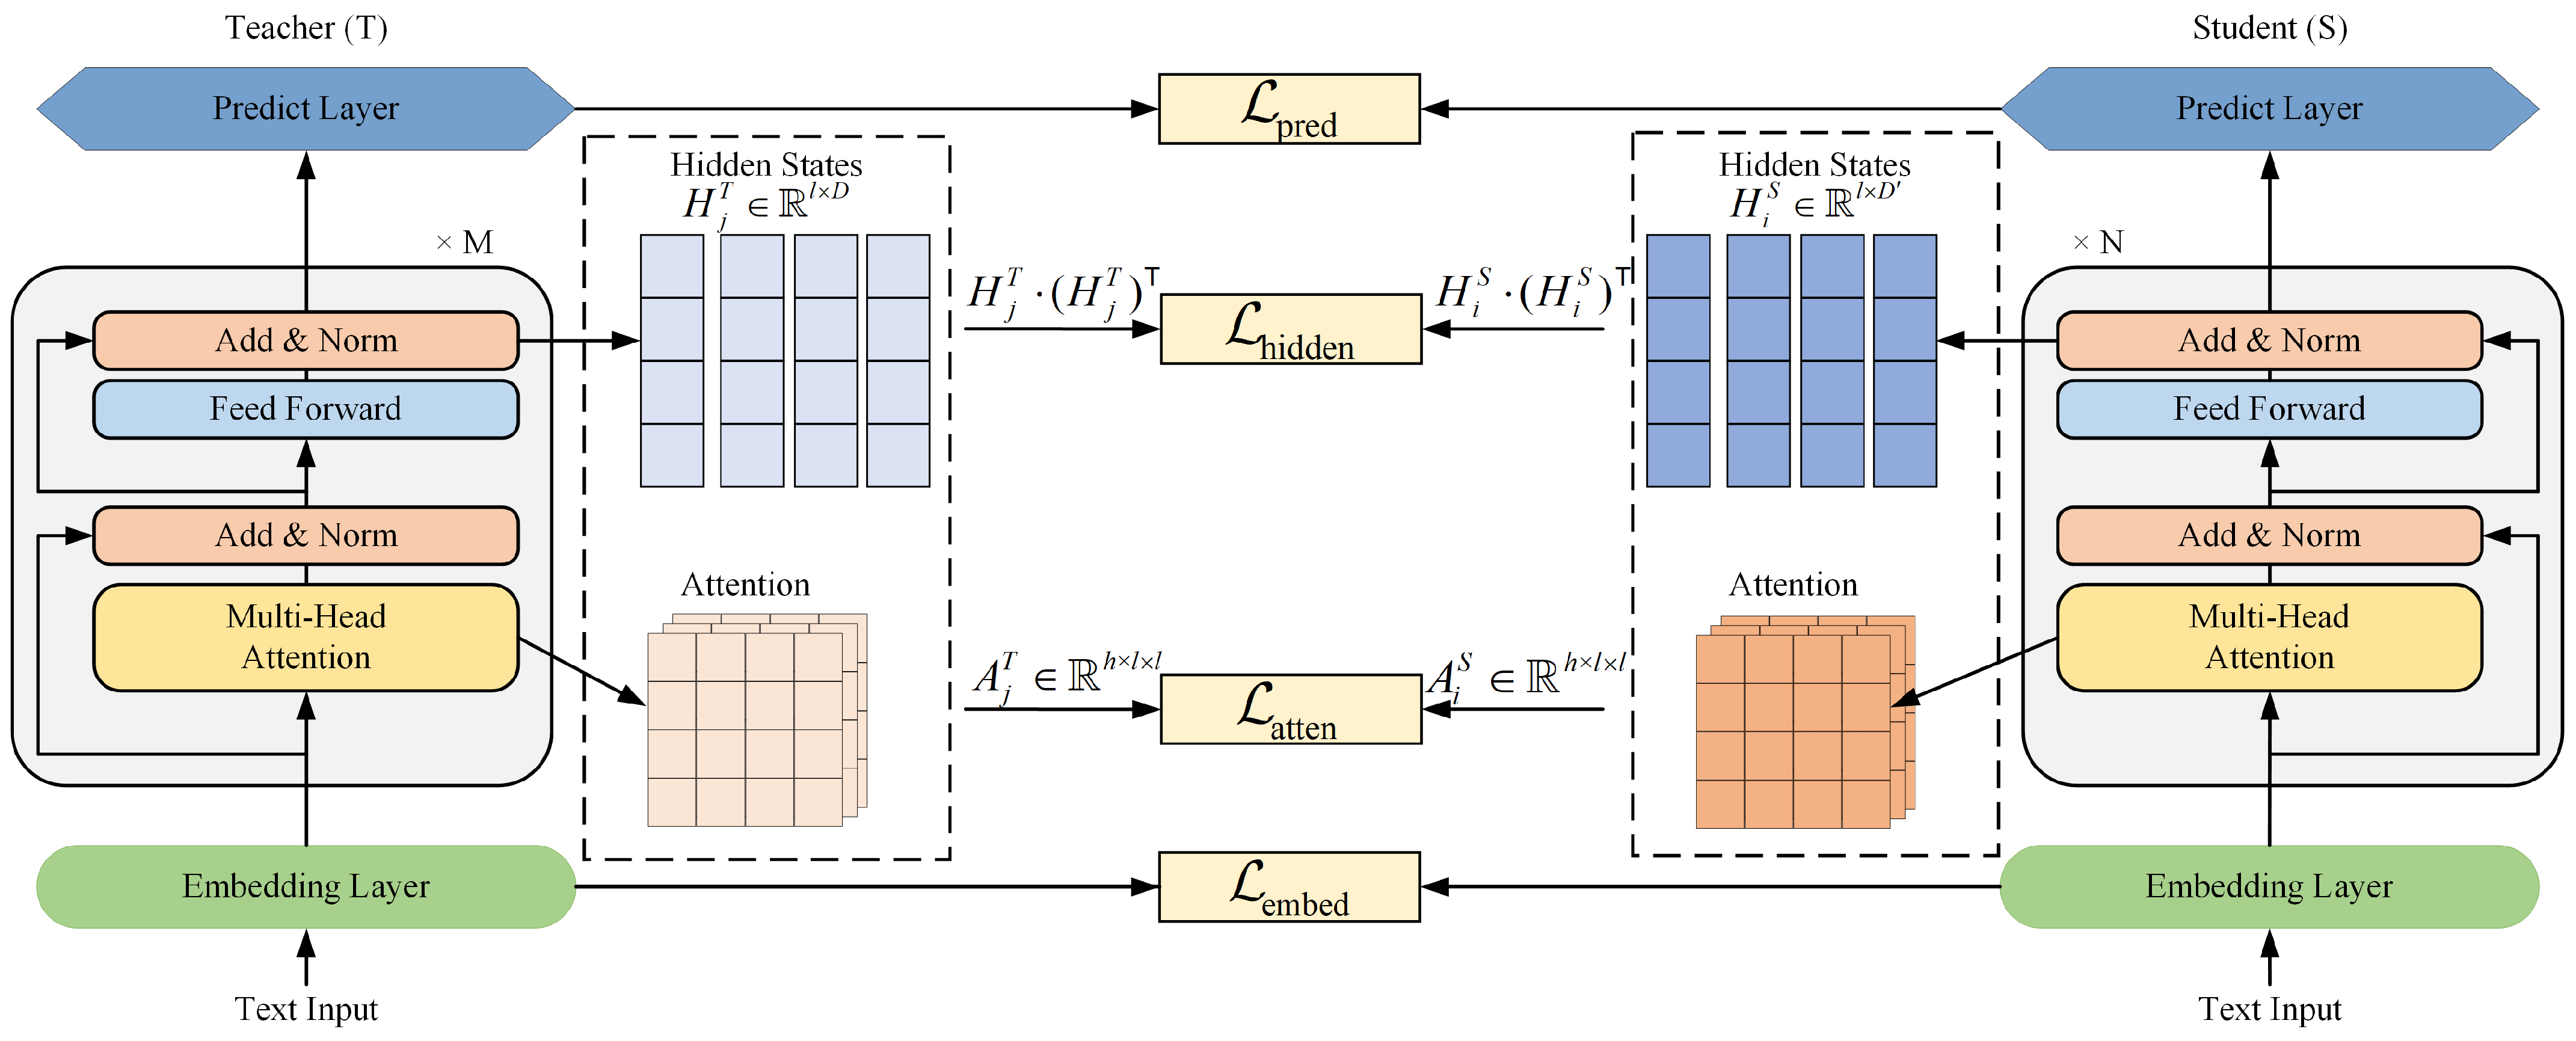

[Источник](https://www.mdpi.com/2076-3417/14/20/9180)

**Задание 2 (0.25 баллов)**. Реализуйте модель ученика.

Для начала создадим модель ученика. Так как наша как можно сильнее ускорить, то попробуем разные комбинации.

In [27]:
model_teacher_config = model_teacher.config

Для начала уменьшим число слоев в 3 раза.

In [28]:
student_config = deepcopy(model_teacher_config)
# YOUR CODE HERE
...

In [29]:
model_student = AutoModelForTokenClassification.from_config(student_config).to(device)

print_numel_parameters(model_student)
time_inference(model_student)
time_inference(model_student)

Число параметров:			 51023625
Число параметров без nn.Embedding:	 28359945
Time: 0.02902 +- 0.00201
Time: 0.02968 +- 0.00163


При такой постановке мы можем ускорить почти в 3 раза. Дополнительно уменьшим размерность FeedForward слоев с 3072 до 2048.

In [30]:
student_config = deepcopy(model_teacher_config)
# YOUR CODE HERE
...

In [31]:
model_student = AutoModelForTokenClassification.from_config(student_config).to(device)

print_numel_parameters(model_student)
time_inference(model_student)
time_inference(model_student)

Число параметров:			 44728073
Число параметров без nn.Embedding:	 22064393
Time: 0.02307 +- 0.00066
Time: 0.02444 +- 0.00175


Последнее изменение, уменьшим скрытую размерность с 768 до 384 (должно быть кратно числу голов, то есть 12).

In [32]:
student_config = deepcopy(model_teacher_config)
# YOUR CODE HERE
...

In [33]:
model_student = AutoModelForTokenClassification.from_config(student_config).to(device)

print_numel_parameters(model_student)
time_inference(model_student)
time_inference(model_student)

Число параметров:			 20008841
Число параметров без nn.Embedding:	 8677001
Time: 0.01111 +- 0.00035
Time: 0.01112 +- 0.00022


Мы смогли уложиться в 20 миллионов параметров. При этом большинство обучаемых параметров хранятся в `nn.Embedding`. Для этого можно факторизовать матрицу эмбеддингов и представить в виде матрицы меньшего ранга. Мы не будем это делать.

Отметим, что при уменьшении скрытой размерности мы больше не можем использовать эмбеддинги учителя в качестве инициализации ученика. Например, в статье [DistilBERT](https://arxiv.org/abs/1910.01108) ограничились уменьшением только числа слоев в 2 раза.

В целом мы выше заметили, что наибольшее ускорение дало именно уменьшение числа слоев, так как attention сложная операция, а все линейные слои хорошо реализованы в современных библиотеках.

Далее мы будем использовать конфиг **с 4 слоями и размерностью FeedForward слоев 2048**, так как мы хотим исследовать влияние дистилляции промежуточных слоев, для этого размерность скрытого представления должна быть одинаковая.

In [34]:
student_config = deepcopy(model_teacher_config)
# YOUR CODE HERE
...

model_student = AutoModelForTokenClassification.from_config(student_config)
print_numel_parameters(model_student)

Число параметров:			 44728073
Число параметров без nn.Embedding:	 22064393


**Задание 3 (1 балл)**. Реализуйте функции потерь для дистилляции.

Для корректной реализации дистилляции нам нужно:

- Уметь считать лосс исходной задачи (в нашем случае NER);
- Считать KL-дивергенцию между распределением ученика и учителя;
- Считать MSE между скрытыми состояниями и картами внимания.


Для лосса исходной задачи нам достаточно вызвать forward модели ученика и достать `loss`. Для KL-дивергенции мы будем использовать `nn.KLDivLoss(reduction="batchmean")` (крайне рекомендуется прочитать документацию).

Для работы со скрытыми состояниями и картами внимания для начала их нужно достать из модели. В hugging face для этого достаточно вызвать forward с аргументами `output_attentions=True`, `output_hidden_states=True`. Мы считаем, что модель ученика именно так и вызывали.

В этом задании вам необходимо правильно подсчитать функцию потерь `distillation_loss`. Основная сложность будет в подсчете $\mathcal{L}_{\text{atten}}$ и $\mathcal{L}_{\text{hideen}}$. Подумайте между какими слоями мы хотим уметь считать близость (посмотрите диаграммы из [статьи](https://www.researchgate.net/publication/375758425_Knowledge_Distillation_Scheme_for_Named_Entity_Recognition_Model_Based_on_BERT))

In [35]:
from transformers.models.bert.modeling_bert import BertForTokenClassification

def distillation_loss(
    outputs,
    labels,
    inputs,
    num_items_in_batch,
    temperature: float,
    alpha: float,
    model_teacher: BertForTokenClassification,
    use_attn_hid: bool,
    kl_loss=nn.KLDivLoss(reduction="batchmean")
):
    student_logits = outputs.logits
    with torch.inference_mode():
        # Use Teacher model
        # YOUR CODE HERE
        ...

    # Calculate kl_loss
    # YOUR CODE HERE
    ...
    soft_loss = ...

    att_loss, hid_loss = 0., 0.
    if use_attn_hid:
        # hint: use teacher_layers % len(outputs.attentions) == 0!
        # Distillation attention loss
        # YOUR CODE HERE
        ...
        att_loss = ...

        # Distillation hidden loss
        # YOUR CODE HERE
        ...
        hid_loss = ...

    # Student loss
    # YOUR CODE HERE
    hard_loss = ...

    return (1. - alpha) * hard_loss + alpha * (soft_loss + att_loss + hid_loss)

Если мы в качестве ученика возьмем модель учителя, то должны получит просто лосс исходной задачи умноженный на (1 - $\alpha$), обратите внимание, что возможна численная нестабильность небольшая, так как KL не всегда точно ноль.

In [36]:
set_global_seed(42)

dataloader = torch.utils.data.DataLoader(
    tokenized_datasets['train'],
    collate_fn=data_collator,
    batch_size=2,
    shuffle=False
)
batch = next(iter(dataloader))
batch = {k: v.to(device) for k, v in batch.items()}

with torch.inference_mode():
    outputs = model_teacher(**batch, output_attentions=True, output_hidden_states=True)
    loss = distillation_loss(
        outputs=outputs,
        labels=None,
        inputs=batch,
        num_items_in_batch=None,
        temperature=1,
        alpha=0.5,
        model_teacher=model_teacher,
        use_attn_hid=True
    )

    print(f"Loss = {loss}")
    print(f"Loss_hard / 2 = {outputs.loss / 2}")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Loss = 7.754525722702965e-05
Loss_hard / 2 = 7.753045065328479e-05


**Задание 4 (0.75 балл)**. Реализуйте класс тренера для задачи дистилляции.

Мы хотим использовать класс `Trainer` из hugging face, так как в нём уже реализовано много высокоуровневого функционала, который не хотелось бы менять. Однако выше мы заметили, что надо вызывать модель ученика с параметрами `output_attentions=True`, `output_hidden_states=True`, однако мы не можем передать эти аргументы при использовании стандартного `Trainer`. Поэтому мы реализуем класс-наследник `DistillTrainer` и переопределим в нем функцию `compute_loss`. Вам необязательно сохранять весь функционал исходной функции, главное правильно вызвать модель и правильно вызывать `self.compute_loss_func`.

In [37]:
from transformers.modeling_outputs import TokenClassifierOutput # hint: use this, it might help.

class DistillTrainer(Trainer):

    # hint use:
    # https://github.com/huggingface/transformers/blob/052e652d6d53c2b26ffde87e039b723949a53493/src/transformers/trainer.py#L3618
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.

        Subclass and override for custom behavior.
        """
        labels = None # We don't use labels
        # YOUR CODE HERE
        ...
        loss = ...

        if self.args.average_tokens_across_devices and self.model_accepts_loss_kwargs:
            loss *= self.accelerator.num_processes

        # YOUR CODE HERE
        outputs = ...
        return (loss, outputs) if return_outputs else loss

Для ускорения будем всё учить в fp16.

In [38]:
distil_training_config = deepcopy(base_config)
distil_training_config['save_strategy'] = 'no'
distil_training_config['learning_rate'] = 5e-05
distil_training_config['fp16'] = True

distil_training_config

{'eval_strategy': 'epoch',
 'save_strategy': 'no',
 'learning_rate': 5e-05,
 'num_train_epochs': 15,
 'warmup_ratio': 0.1,
 'weight_decay': 0.01,
 'push_to_hub': False,
 'report_to': 'none',
 'fp16': True}

Обернем создание лосса в функцию, чтобы `DistillTrainer` мог использовать лосс напрямую.

In [39]:
def get_loss_fn(loss_type, alpha, temperature, model_teacher):
    assert loss_type in ['base', 'attn_hidden'], f"loss_type = {loss_type}"
    use_attn_hid = loss_type == 'attn_hidden'
    return partial(distillation_loss, temperature=temperature, alpha=alpha, model_teacher=model_teacher, use_attn_hid=use_attn_hid)

Создадим функцию `get_distil_trainer`, которая будет создавать модель всегда с одной инициализацией для корректного сравнения.

In [40]:
def get_distil_trainer(
    loss_type: str,
    alpha: float,
    temperature: float,
    num_epoch: int,
    training_conf: dict,
    student_config: dict,
    model_teacher=model_teacher,
    datasets=tokenized_datasets,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    seed=42
):
    set_global_seed(seed)

    name = f"student_{alpha}_{temperature}_{loss_type}"
    config = deepcopy(training_conf)
    config['num_train_epochs'] = num_epoch
    args = TrainingArguments(
        name,
        run_name=name,
        dataloader_drop_last=True,
        **config
    )

    student_loss = get_loss_fn(loss_type, alpha, temperature, model_teacher)
    model_student = AutoModelForTokenClassification.from_config(student_config)
    distil_trainer = DistillTrainer(
        model=model_student,
        args=args,
        train_dataset=datasets["train"],
        eval_dataset=datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        processing_class=processing_class,
        compute_loss_func=student_loss
    )

    print("YOUR TRAINING CONFIG")
    print(f"RUN NAME = {name}")
    print(training_conf)
    print("=" * 40)

    return distil_trainer

### `Проверка корректности и baseline`

Прежде, чем проводить основные эксперименты и перебирать $\alpha$ и температуру в Softmax, для начала проверим, что в мы ничего не сломали. Кроме того, нам будет полезно знать как учится модель без функции потерь от дистилляции. Так мы сможем понять насколько наши нововведения полезны и улучшают обучение.

In [41]:
alpha, temperature = 0., 1.
loss_type="base"
dist_trainer = get_distil_trainer(
    loss_type=loss_type,
    alpha=alpha,
    temperature=temperature,
    num_epoch=5,
    training_conf=distil_training_config,
    student_config=student_config,
)

YOUR TRAINING CONFIG
RUN NAME = student_0.0_1.0_base
{'eval_strategy': 'epoch', 'save_strategy': 'no', 'learning_rate': 5e-05, 'num_train_epochs': 15, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'push_to_hub': False, 'report_to': 'none', 'fp16': True}


In [42]:
dist_trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.408700,0.335873,0.451110
2,0.196600,0.244075,0.588006
3,0.123800,0.228433,0.642340
4,0.074700,0.228602,0.664826
5,0.046700,0.235253,0.693086


TrainOutput(global_step=8775, training_loss=0.21860842789000595, metrics={'train_runtime': 585.0101, 'train_samples_per_second': 120.006, 'train_steps_per_second': 15.0, 'total_flos': 398283828497568.0, 'train_loss': 0.21860842789000595, 'epoch': 5.0})

Теперь проверим, что мы нигде не ошиблись в дистилляции. В статье [https://arxiv.org/abs/1910.01108](https://arxiv.org/abs/1910.01108) отметили (Table 4), что отказ от функции потерь исходной задачи, приводит к просадке качества на 0.31 (что мало). Значит мы ожидаем, что если в коде нет ошибки, то качество не сильно поменяется.

In [43]:
alpha, temperature = 1., 1.
loss_type="base"
dist_trainer = get_distil_trainer(
    loss_type=loss_type,
    alpha=alpha,
    temperature=temperature,
    num_epoch=5,
    training_conf=distil_training_config,
    student_config=student_config,
)

YOUR TRAINING CONFIG
RUN NAME = student_1.0_1.0_base
{'eval_strategy': 'epoch', 'save_strategy': 'no', 'learning_rate': 5e-05, 'num_train_epochs': 15, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'push_to_hub': False, 'report_to': 'none', 'fp16': True}


In [44]:
dist_trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,23.258900,15.952113,0.451738
2,12.323600,12.477705,0.556795
3,8.987400,10.472813,0.616474
4,6.217500,9.961872,0.672329
5,5.141000,9.888724,0.676236


TrainOutput(global_step=8775, training_loss=13.108819360977565, metrics={'train_runtime': 524.3716, 'train_samples_per_second': 133.884, 'train_steps_per_second': 16.734, 'total_flos': 398283828497568.0, 'train_loss': 13.108819360977565, 'epoch': 5.0})

Аналогичный эксперимент если вы хотите (в качестве проверки), вы можете провести с участием дистилляции скрытых и attention слоев.

In [45]:
alpha, temperature = 1., 1.
loss_type="attn_hidden"
dist_trainer = get_distil_trainer(
    loss_type=loss_type,
    alpha=alpha,
    temperature=temperature,
    num_epoch=5,
    training_conf=distil_training_config,
    student_config=student_config,
)
dist_trainer.train()

YOUR TRAINING CONFIG
RUN NAME = student_1.0_1.0_attn_hidden
{'eval_strategy': 'epoch', 'save_strategy': 'no', 'learning_rate': 5e-05, 'num_train_epochs': 15, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'push_to_hub': False, 'report_to': 'none', 'fp16': True}


Epoch,Training Loss,Validation Loss,F1
1,24.769900,17.305738,0.450505
2,13.664100,13.837864,0.559136
3,10.293000,11.703540,0.613985
4,7.474200,11.115704,0.669587
5,6.373400,11.002203,0.675331


TrainOutput(global_step=8775, training_loss=14.46721578136129, metrics={'train_runtime': 530.4096, 'train_samples_per_second': 132.36, 'train_steps_per_second': 16.544, 'total_flos': 398283828497568.0, 'train_loss': 14.46721578136129, 'epoch': 5.0})

**Выводы**:

-
-


### `Рубрика эксперименты`

В этой секции вам нужно провести эксперименты и понять как дистилляция влияет на обучение. Дизайн экспериментов зависит только от вас. Должны быть выполнены следующие требования:

- Для корректных вывод модель должна быть дообучена. Например, 5 эпох как выше будет недостаточно, 15 эпох будет достаточно;
- В экспериментах на $\alpha$ нужно проверить минимум 3 разных значения;
- В экспериментах на температуру нужно проверить минимум 3 разных значения;
- В экспериментах нужно проверять "разумные" значения для корректных выводов (в каждом пункте будут пояснения о "разумных" значения);
- Ваши выводы должны следовать из экспериментов проведенных в ноутбуке;
- Между всеми запусками гиперпараметры, кроме проверяемых, должны быть одинаковы;
- Проверяйте гипотезы на `loss_type="attn_hidden"`, если вы хотите изменить этот параметр, то должна быть аргументация и эксперименты, её подтверждающие;
- В каждом задании должны быть написаны выводы и ответ на соответствующий вопрос.

В случае нарушении любого из требований задание **не будет** засчитано.

**Задание 5 (1 балл)**. Исследование влияния температуры.

Мы знаем, что модели бывают слишком уверенные в ответе, то есть вероятность для одного класса сильно выше, чем для всех остальных. Параметр температуры в Softmax отвечает за "сглаживание" распределения (чем выше температура, тем более равномерное распределение).

Проверьте как минимум 3 разных значения температуры. Например, значения равное 1 считается "разумным", а значение температуры 0.01 или 100 таковыми не считаются. Вам необходимо ответить на вопрос: **Как температура влияет на обучение и на итоговое качество?**.

Параметр $\alpha$ можете взять 0.5 как что-то естественное в случае комбинации двух функций потерь. Кроме того, давайте отдельно посмотрим на распределения классов для какого-то объекта и на основе этого найдем ещё одно "разумное" значение.

In [46]:
set_global_seed(42)

dataloader = torch.utils.data.DataLoader(
    tokenized_datasets['train'],
    collate_fn=data_collator,
    batch_size=1,
    shuffle=True
)
batch = next(iter(dataloader))
batch = {k: v.to(device) for k, v in batch.items()}

In [47]:
with torch.inference_mode():
    logits = model_teacher(**batch).logits[0]

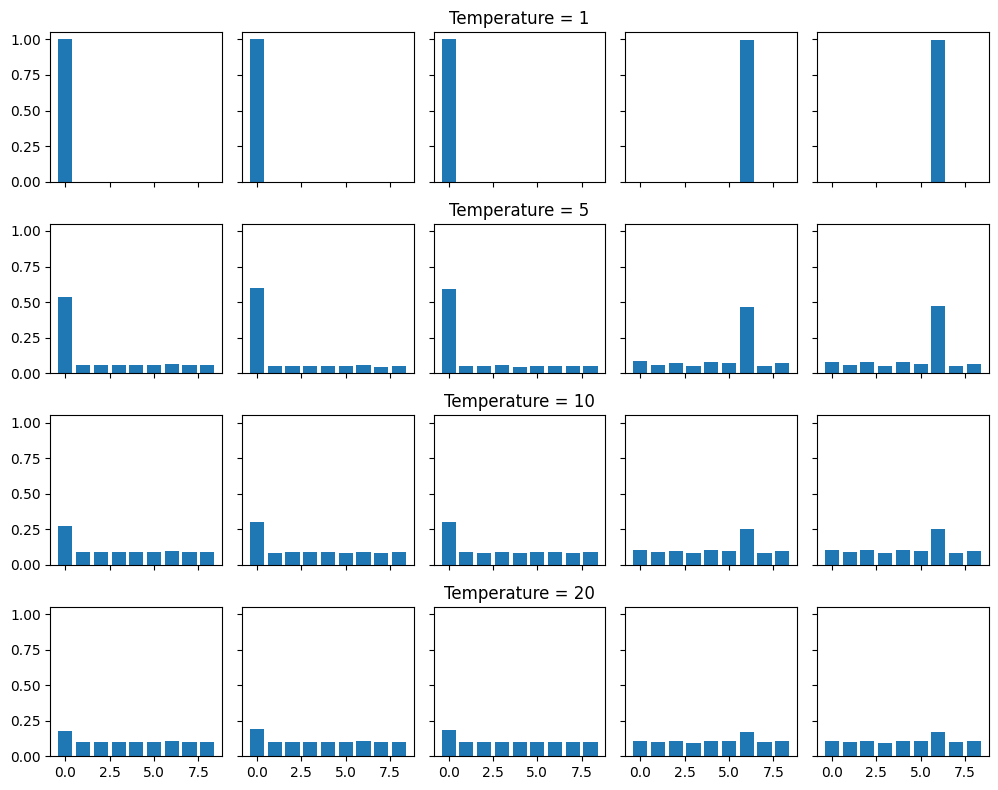

In [48]:
t_grid = [1, 5, 10, 20]
idx_grid = [0, 4, 1, 7, 9]

fig, ax = plt.subplots(len(t_grid), len(idx_grid), figsize=(2 * len(idx_grid), 2 * len(t_grid)), sharex=True, sharey=True)
for i, t in enumerate([1, 5, 10, 20]):
    ax[i, 2].set_title(f"Temperature = {t}")
    for j, idx in enumerate(idx_grid):
        ax[i, j].bar(range(9), (logits[idx] / t).softmax(0).detach().cpu().numpy())

plt.tight_layout()
plt.show()

На основе этих графиков можно сделать вывод, что проверять температуру меньше 1 нет смысла. Проверить 1 стоит, так как это стандартный Softmax.

In [51]:
temperature_grid = ...
alpha = 0.5
loss_type="attn_hidden"

for temperature in temperature_grid:
    dist_trainer = get_distil_trainer(
        loss_type=loss_type,
        alpha=alpha,
        temperature=temperature,
        num_epoch=15,
        training_conf=distil_training_config,
        student_config=student_config,
    )
    dist_trainer.train()

**Выводы**:

-
-


**Задание 6 (1 балл)**. Исследование влияния $\alpha$.

Вы можете выбрать лучший параметр температуры из прошлого пункта, а можете зафиксировать 1.

Проверьте как минимум 3 разных значения $\alpha$. Например, значения равное 0.5 считается "разумным", а значение температуры 0.00001 или 0.99999 таковыми не считаются. Вам необходимо ответить на вопрос: **Как  $\alpha$ влияет на обучение и на итоговое качество?**.

Вы решаете задачу оптимизации вида:

\begin{equation}
(1 - \alpha) \cdot \mathcal{L}_{\text{hard}} + \alpha \cdot \mathcal{L}_{\text{distill}}.
\end{equation}

Обычно, вы хотите, что оба лосса одинаково влияли на оптимизацию и учитывались в процессе оптимизации, то есть чтобы нормы градиентов были одинаковые. Для этого можно подобрать параметр $\alpha$ так, чтобы нормы градиентов по каждому из лоссов были примерно похожи (не стоит выбирать значение до 5 знака после запятой). Иногда, так делать бывает лень, поэтому можно подобрать параметр $\alpha$ так, чтобы $(1 - \alpha) \cdot \mathcal{L}_{\text{hard}} \approx \alpha \cdot \mathcal{L}_{\text{distill}}$. То есть вместо похожести нормы градиентов, мы требуем похожесть самих значений функции. Понятно, что такой подход не даст похожие нормы градиентов, однако на практике сильно проще в реализации. Например, если у вас первый лосс равен 100, а второй 1, то стоит взять $\frac{1 - \alpha}{\alpha} \approx \frac{1}{100}$, то есть $\alpha \approx  \frac{100}{101}$, значит можно взять $\alpha = 0.99$.

Найденные таким способом $\alpha$ будут считаться "разумными".

**Бонус (0.1 балла)**. Реализуйте метод, который возьмет батч и при фиксированной температуре посчитает нормы градиентов $\mathcal{L}_{\text{hard}}$ и $\mathcal{L}_{\text{distill}}$. После чего на анализе этих норм подберите нужное $\alpha$.

In [52]:
alpha_grid = ...
temperature = 5
loss_type="attn_hidden"

for alpha in alpha_grid:
    dist_trainer = get_distil_trainer(
        loss_type=loss_type,
        alpha=alpha,
        temperature=temperature,
        num_epoch=15,
        training_conf=distil_training_config,
        student_config=student_config,
    )
    dist_trainer.train()

**Выводы**:

-
-


**Бонус (1 балл)**. Выбить качество выше 0.85, если вы сделали это раньше, то необходимо продублировать конфиг. Вы можете использовать следующее:

- Проинцилизировать эмбеддинги студента через учителя;
- Проинцилизировать слои attention студента через учителя;
- Предобучит модель студента с помощью дисстиляции на задаче MLM, так как обучать трансформер сразу на итоговую задачу не стоит;
- Подробнее изучить статью [DistilBERT](https://arxiv.org/pdf/1910.01108).

Если вы не смогли выбить качество выше 0.85, но реализовали первые три пункта корректно, то пункт будет засчитан.

## `Квантизация (3.5 балла)`

В этом задании вам будет предложено квантизировать модель в int8, так вы сможете уменьшить потребляюмую память и быстрее умножать матрицы! Мы будем основываться на методе [SmoothQuant](https://arxiv.org/abs/2211.10438), однако не будем делать Smooth, то есть сглаживание весов. Основная проблема возникает в том, что метод разработан для `Pre-Normalization` трансформеров, когда первые модели и в частности BERT имеют архитектуру `Post-Normalization`. Идейно отличие в том, что в первом случае слой LayerNorm размешается в начале блока, во втором случае - в конце. Подробнее можете почитать [в статье](https://arxiv.org/abs/2002.04745).


Загрузим модель.

In [53]:
model_teacher = AutoModelForTokenClassification.from_pretrained('3145tttt/bert-cased-ner-mmp-task3').to(device)
model_teacher = model_teacher.eval()
model_teacher = model_teacher.requires_grad_(False)

**Задание 7 (0.5 балл)**

Теперь наша цель научиться правильно округлять в 8 бит веса линейных слоев и активации. Для этого реализуем 2 функции: `quantize_weight_per_channel_absmax`, `quantize_activation_per_token_absmax`.

Сначала разберемся с весами, нам нужно реализовать формулу:

\begin{equation}
 X^{\text{INT8}} = \text{round}(\frac{X^{\text{FP16}}}{\Delta}), \quad \Delta = \frac{max(|X|)}{ 2^{8 - 1} - 1 },
\end{equation}
где $X^{\text{FP16}}$ веса в fp16, $X^{\text{INT8}}$ желаемые веса в int8. Мы эту операцию будем производить не для всего тензора весов, а для каждого выходного канала. Заметим, что все операции хорошо бродкастятся, поэтому вам будет достаточно просто применить исходную функцию только заменить операцию максимума, на максимум по каналам.

**Важно**. Учтите, что может возникнуть деление на 0.

In [54]:
@torch.no_grad()
def quantize_weight_per_channel_absmax(w, n_bits=8):
    """
    Args:
        w: (out_features, in_features)
    """
    # YOUR CODE HERE
    scales = ... # numerator in \Delta from formula
    ...
    return w

In [55]:
w = torch.tensor([
    [-2, -2, 1, 2],
    [-3, -1, 2, 6],
    [-1, -5, 4, 1],
    [0,   0, 0, 0]
]).float()
quantize_weight_per_channel_absmax(w)

tensor([[-2.0000, -2.0000,  1.0079,  2.0000],
        [-3.0236, -0.9921,  1.9843,  6.0000],
        [-0.9843, -5.0000,  4.0157,  0.9843],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])

Для умножения матриц в int8, нам нужно, чтобы обе матрицы были в int8, значит нужно уметь квантовать активации. Будем действовать аналогично матрице весов, только теперь мы не знаем сколько размерностей у каждого токена, поэтому сначала нужно сделать правильный view на тензор активаций. Учтите, что наша цель применить операцию для каждого токена, для этого нужно выбрать нужную размерность.

In [56]:
@torch.no_grad()
def quantize_activation_per_token_absmax(t, n_bits=8):
    """
    Args:
        t: (d0, ..., dn, token_embedding_dim)
    """
    t_shape = t.shape
    # YOUR CODE HERE
    ...
    scales = ... # numerator in \Delta from formula
    ...
    return t

In [57]:
t = torch.tensor([
    [-2, -2, 1, 2],
    [-3, -1, 2, 6],
    [-1, -5, 4, 1],
    [-5, -2, 1, 2]
]).float()
t = t.view(2, 4, 2)
print(t)
quantize_activation_per_token_absmax(t)

tensor([[[-2., -2.],
         [ 1.,  2.],
         [-3., -1.],
         [ 2.,  6.]],

        [[-1., -5.],
         [ 4.,  1.],
         [-5., -2.],
         [ 1.,  2.]]])


tensor([[[-2.0000, -2.0000],
         [ 1.0079,  2.0000],
         [-3.0000, -0.9921],
         [ 1.9843,  6.0000]],

        [[-0.9843, -5.0000],
         [ 4.0000,  1.0079],
         [-5.0000, -2.0079],
         [ 1.0079,  2.0000]]])

Все функции выше были необходимы для реализации линейного слоя!

In [58]:
class W8A8Linear(nn.Module):
    # This class implements fake quantization.
    # It performs all computations in FP16 but simulates the effects of quantization
    def __init__(
        self,
        in_features,
        out_features,
        bias=True,
        act_quant="per_token",
        quantize_output=False,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.register_buffer(
            "weight",
            torch.randn(
                self.out_features,
                self.in_features,
                dtype=torch.float16,
                requires_grad=False,
            ),
        )
        if bias:
            self.register_buffer(
                "bias",
                torch.zeros(
                    (1, self.out_features), dtype=torch.float16, requires_grad=False
                ),
            )
        else:
            self.register_buffer("bias", None)

        if act_quant == "per_token":
            self.act_quant_name = "per_token"
            self.act_quant = partial(quantize_activation_per_token_absmax, n_bits=8)
        else:
            raise ValueError(f"Invalid act_quant: {act_quant}")

        if quantize_output:
            self.output_quant_name = self.act_quant_name
            self.output_quant = self.act_quant
        else:
            self.output_quant_name = "None"
            self.output_quant = lambda x: x

    def to(self, *args, **kwargs):
        super(W8A8Linear, self).to(*args, **kwargs)
        self.weight = self.weight.to(*args, **kwargs)
        if self.bias is not None:
            self.bias = self.bias.to(*args, **kwargs)
        return self

    @torch.no_grad()
    def forward(self, x):
        q_x = self.act_quant(x)
        y = torch.functional.F.linear(q_x, self.weight, self.bias)
        q_y = self.output_quant(y)
        return q_y

    @staticmethod
    def from_float(
        module, weight_quant="per_channel", act_quant="per_token", quantize_output=False
    ):
        assert isinstance(module, torch.nn.Linear)
        new_module = W8A8Linear(
            module.in_features,
            module.out_features,
            module.bias is not None,
            act_quant=act_quant,
            quantize_output=quantize_output,
        )
        if weight_quant == "per_channel":
            new_module.weight = quantize_weight_per_channel_absmax(
                module.weight, n_bits=8
            )  # use 8-bit integer for weight
        else:
            raise ValueError(f"Invalid weight_quant: {weight_quant}")

        new_module.weight_quant_name = weight_quant
        if module.bias is not None:
            new_module.bias = module.bias
        return new_module

    def __repr__(self):
        return f"W8A8Linear({self.in_features}, {self.out_features}, bias={self.bias is not None}, weight_quant={self.weight_quant_name}, act_quant={self.act_quant_name}, output_quant={self.output_quant_name})"

Проверим корректность реализации, для этого создадим линейный слой и посмотрим как меняются его веса и выход.

In [59]:
linear_teacher = nn.Linear(4, 4)

linear_teacher.bias.data = torch.tensor([-2, -1, 1, 2]).float()
linear_teacher.weight.data = torch.tensor([
    [-2, -2, 1, 2],
    [-3, -1, 2, 6],
    [-1, -5, 4, 1],
    [-5, -2, 1, 2]
]).float()
x_testing = torch.linspace(-5, 5, 4)[None, :]
out_teacher_linear = linear_teacher(x_testing)
out_teacher_linear

tensor([[23.0000, 49.0000, 26.0000, 42.0000]], grad_fn=<AddmmBackward0>)

In [60]:
linear_quant = W8A8Linear.from_float(linear_teacher, quantize_output=False)
linear_quant.weight, linear_quant.bias, linear_quant(x_testing)

(Parameter containing:
 tensor([[-2.0000, -2.0000,  1.0079,  2.0000],
         [-3.0236, -0.9921,  1.9843,  6.0000],
         [-0.9843, -5.0000,  4.0157,  0.9843],
         [-5.0000, -2.0079,  0.9843,  2.0079]], requires_grad=True),
 Parameter containing:
 tensor([-2., -1.,  1.,  2.], requires_grad=True),
 tensor([[22.9736, 49.0397, 25.7505, 41.9870]]))

In [61]:
linear_quant = W8A8Linear.from_float(linear_teacher, quantize_output=True)
linear_quant.weight, linear_quant.bias, linear_quant(x_testing)

(Parameter containing:
 tensor([[-2.0000, -2.0000,  1.0079,  2.0000],
         [-3.0236, -0.9921,  1.9843,  6.0000],
         [-0.9843, -5.0000,  4.0157,  0.9843],
         [-5.0000, -2.0079,  0.9843,  2.0079]], requires_grad=True),
 Parameter containing:
 tensor([-2., -1.,  1.,  2.], requires_grad=True),
 tensor([[22.7822, 49.0397, 25.8713, 42.0892]]))

Теперь необходимо квантизовать все линейные слои внутри `Attention` и `Feedforward`. Для этого может быть полезно посмотреть на архитектуры модели.

**Задание 8 (0.5 балл)** Квантизовать BERT.

Теперь вам необходимо квантизовать модель! Мы хотим заменить все линейные слои в attention и FeedForward блоках. Внимательно посмотрите на архитектуру и замените все нужные слои. Замену слоя можно произвести с помощью функции `W8A8Linear.from_float`.

In [62]:
model_teacher.bert.encoder

BertEncoder(
  (layer): ModuleList(
    (0-11): 12 x BertLayer(
      (attention): BertAttention(
        (self): BertSdpaSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [63]:
from transformers.models.bert.modeling_bert import BertAttention, BertIntermediate, BertOutput

In [64]:
def quantize_bert_like(
    model, weight_quant="per_channel", act_quant="per_token", quantize_bmm_input=False,
    quantize_ff=True, quantize_attention=True
):

    for name, m in model.bert.named_modules():
        # For FF layers
        if isinstance(m, BertIntermediate) and quantize_ff:
            # YOUR CODE HERE
            ...
        elif isinstance(m, BertOutput) and quantize_ff:
            # YOUR CODE HERE
            ...
        # For Attention layers
        elif isinstance(m, BertAttention) and quantize_attention:
            # Here we simulate quantizing inputs by quantizing the output of query, key, value and output linear
            # YOUR CODE HERE
            ...
    return model

Проверим как отработала квантизация, для этого создадим копию модели и проверим выход на каком-то фиксированном батче.

In [65]:
set_global_seed(42)
dataloader = torch.utils.data.DataLoader(
    tokenized_datasets['train'],
    collate_fn=data_collator,
    batch_size=2,
    shuffle=False
)
batch = next(iter(dataloader))
batch = {k: v.to(device) for k, v in batch.items()}

In [66]:
outputs_teacher = model_teacher(**batch)
outputs_teacher.loss.item()

0.00015506090130656958

In [67]:
model_quant = deepcopy(model_teacher)
model_quant = quantize_bert_like(model_quant)
outputs_quant = model_quant(**batch)

outputs_quant.loss.item()

0.00016010466788429767

Напишем функции для подсчета доли квантизованных параметров и валидации.

In [68]:
def print_numel_quant_parameters(model):
    num_quant_params = 0
    for name, m in model.named_modules():
        if isinstance(m, W8A8Linear):
            num_quant_params += sum(p.numel() for p in m.parameters())

    num_params = sum(p.numel() for p in model.parameters())
    print(f'Число параметров: {num_params}')
    print(f'Число квантизованных параметров: {num_quant_params}')
    print(f'Доля квантизованных параметров: {num_quant_params / num_params:0.4f}%')

In [69]:
def eval_quant_model(model_teacher, quantize_attention, quantize_ff, quantize_bmm_input=False):

    model_quant = deepcopy(model_teacher)
    model_quant = quantize_bert_like(
        model_quant,
        quantize_attention=quantize_attention,
        quantize_ff=quantize_ff,
        quantize_bmm_input=quantize_bmm_input
    )
    print_numel_quant_parameters(model_quant)
    eval_model(model_quant)

    del model_quant

Для начала ещё раз посчитаем качество исходной модели.

In [70]:
eval_model(model_teacher)

F1 = 0.94654


Попробуем квантизовать разные части модели.

In [71]:
eval_quant_model(model_teacher, quantize_attention=True, quantize_ff=True)

Число параметров: 107726601
Число квантизованных параметров: 85017600
Доля квантизованных параметров: 0.7892%


F1 = 0.94505


In [72]:
eval_quant_model(model_teacher, quantize_attention=False, quantize_ff=True)

Число параметров: 107726601
Число квантизованных параметров: 56669184
Доля квантизованных параметров: 0.5260%


F1 = 0.94517


In [73]:
eval_quant_model(model_teacher, quantize_attention=True, quantize_ff=False)

Число параметров: 107726601
Число квантизованных параметров: 28348416
Доля квантизованных параметров: 0.2632%


F1 = 0.94661


На практике нас интересует, когда квантизуется и вход слоя, так как мы хотим эффективно умножить матрицу $X$ на матрицу весов $W$.

In [74]:
eval_quant_model(model_teacher, quantize_attention=True, quantize_ff=True, quantize_bmm_input=True)

Число параметров: 107726601
Число квантизованных параметров: 85017600
Доля квантизованных параметров: 0.7892%


F1 = 0.94574


Сделаем замеры времени.

In [75]:
model_quant = deepcopy(model_teacher)
model_quant = quantize_bert_like(
    model_quant,
    quantize_attention=True,
    quantize_ff=True,
    quantize_bmm_input=True
)

In [76]:
time_inference(model_quant)
time_inference(model_quant)

Time: 0.04431 +- 0.00860
Time: 0.04300 +- 0.00467


In [77]:
time_inference(model_teacher)
time_inference(model_teacher)

Time: 0.02584 +- 0.00739
Time: 0.02134 +- 0.00066


**Выводы**:

-
-


### `Квантизация с помощью Triton (2 балла)`

**Важно:** авторы настоятельно рекомендуют выполнять эту часть домашнего задания в Google Colab и не гарантируют поддержку других сред.

Теперь мы перейдем от *симуляции* квантизации к *настоящей* INT8-квантизации. Вместо того чтобы квантовать и сразу деквантовать значения, мы будем хранить веса в INT8 и выполнять матричные умножения в INT8, что позволяет значительно ускорить вычисления на GPU.

Тогда квантизация будет выглядеть так:
- Перед этапом инференса мы квантизуем веса модели в INT8
- Во время forward-а каждого линейного слоя мы квантизуем активацию в INT8, выполняем перемножение матриц в INT8, после чего деквантизуем результат.

Для этого мы будем использовать [**Triton**](https://triton-lang.org/main/index.html).

Мы реализуем следующие компоненты:
1. `quantize_int8_perrow_kernel`: Triton-kernel для быстрой квантизации активаций (матрицы `X`) в INT8. Квантизация будет происходить "на лету" для каждой строки (токена).
2. `perrow_w8a8_matmul_kernel`: Triton-kernel для выполнения матричного умножения `C = A @ B`, где и `A` (активации), и `B` (веса) являются матрицами в формате INT8. В качестве алгоритма матричного умножения **нужно использовать tiled-matmul**, который вы реализовывали в первом домашнем задании. Только в этот раз используйте Triton и INT8.
3. `TritonW8A8Linear`: Новый `nn.Module`, который заменит `nn.Linear` и будет использовать наши Triton-kernels для вычислений.

Давайте интегрируем предоставленные ядра в наш пайплайн.

Полезные ссылки:
- [Matrix Multiplication Background User's Guide](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html)
- [Deep Dive on CUTLASS Ping-Pong GEMM Kernel](https://pytorch.org/blog/cutlass-ping-pong-gemm-kernel/)
- [Accelerating 2D Dynamic Block Quantized Float8 GEMMs in Triton](https://pytorch.org/blog/accelerating-gemms-triton/)
- [Домашнее задание ШАДа, на котором основано эта часть ДЗ](https://github.com/mryab/efficient-dl-systems/blob/main/week09_inference_algorithms/homework/hw-w8a8-specdec.ipynb). В нем реализована часть нужного вам кода, если вы понимаете, что ничего не понимаете, то советуем сперва вам разобраться, а только потом смотреть туда.


**Подсказка**. В этом пункте нет тестов, но вы можете сами проверить отдельные слои, так как вы реализуете матричные умножения. Операция квантизации не должна особо сильно менять веса, значит выходы слоев должны быть похожи. Если у вас не получилось сразу реализовать проход через все слои, то проверьте какой-нибудь слой отдельно.

In [78]:
import triton
import triton.language as tl
print("triton version:", triton.__version__)

triton version: 3.2.0


In [79]:
def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"
assert is_cuda(), "CUDA only part"

In [80]:
def get_cuda_autotune_config():
    return [
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        # custom
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 4, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
    ]


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    raise NotImplementedError("ooops")

In [81]:
@triton.autotune(
    configs=[
        triton.Config({}, num_stages=2, num_warps=8),
        triton.Config({}, num_stages=2, num_warps=4),
        triton.Config({}, num_stages=2, num_warps=2),
        triton.Config({}, num_stages=2, num_warps=1),
    ],
    key=['K'],
)
@triton.jit
def quantize_int8_perrow_kernel(
    fpa_ptr, a_ptr, as_ptr,
    M, K,
    stride_fpam, stride_fpak,
    stride_am, stride_ak,
    stride_asm,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
):
    # Create current program mask
    # YOUR CODE HERE
    pid_m = ...
    offs_k = ...
    offs_am = ...
    
    # YOUR CODE HERE

    # Compute per-row maximum absolute value
    # YOUR CODE HERE
    fpa_ptrs = ...
    a_ptrs = ...
    a_max = ...
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        ...

    # YOUR CODE HERE
    # divide a_max by max positive INT8 value
    a_scale = ...

    # Devide fpa by a_scale and convert to INT8
    # YOUR CODE HERE
    fpa_ptrs = ...
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        ...

    # Write the result
    # YOUR CODE HERE
    as_offs = ...
    tl.store(...)


def quantize_int8_perrow(fpa):
    a = torch.empty(fpa.shape, device=fpa.device, dtype=torch.int8)
    a_scale = torch.empty(fpa.shape[0], device=fpa.device, dtype=fpa.dtype)
    M, K = fpa.shape
    BLOCK_SIZE_M = 1
    BLOCK_SIZE_K = triton.next_power_of_2(K)
    grid = (M // BLOCK_SIZE_M,)
    quantize_int8_perrow_kernel[grid](
        fpa, a, a_scale,
        M, K,
        fpa.stride(0), fpa.stride(1),
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        BLOCK_SIZE_M, BLOCK_SIZE_K,
    )
    return a, a_scale

In [82]:
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
    reset_to_zero=['c_ptr']
)
@triton.jit
def perrow_w8a8_matmul_kernel(
    # Pointers to matrices
    a_ptr, as_ptr, b_ptr, bs_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_asm,
    stride_bk, stride_bn,
    stride_bsn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, SPLIT_K: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # YOUR CODE HERE
    pid = ...
    ...
    pid_m = ...
    pid_n = ...
    # YOUR CODE HERE

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # YOUR CODE HERE
    offs_am = ...
    offs_bn = ...
    offs_k = ...
    a_ptrs = ...
    b_ptrs = ...
    as_ptrs = ...
    bs_ptrs = ...
    a_scale = ...
    b_scale = ..
    
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of int32 values for higher accuracy.
    # `accumulator` will be converted back to int8 after the loop.

    # Create accumulator of int32 dtype
    # YOUR CODE HERE
    accumulator = ...

    # Implement the loop over K dimension.
    # In the loop first load next blocks of A and B, using an appropriate mask over K dimension.
    # Then, multiply blocks and update the accumulator
    # Finally, update the pointers to A and B matrix.
    # You can rely on implementation of regular matmul from the seminar

    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K * SPLIT_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0)
        # We accumulate along the K dimension.
        # YOUR CODE HERE
        ...
        # Advance the ptrs to the next K block.
        a_ptrs += ...
        b_ptrs += ...

    # Dequantize the accumulator with a_scale and b_scale (outer product) and convert to c_ptr.dtype.element_ty
    # YOUR CODE HERE
    c = ...

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    # YOUR CODE HERE
    offs_cm = ...
    offs_cn = ...
    c_ptrs = ...
    c_mask = ...
    if SPLIT_K == 1:
        ...
    else:
        ...


def matmul_int8(a, a_scale, b, b_scale, out=None):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    if out == None:
        c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    else:
        c = out.fill_(0.)
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        META['SPLIT_K'],
    )
    perrow_w8a8_matmul_kernel[grid](
        a, a_scale, b, b_scale, c,
        M, N, K,
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        b.stride(0), b.stride(1),
        b_scale.stride(0),
        c.stride(0), c.stride(1),
    )
    return c

In [83]:
def quantize_int8(weight, axis=0):
    '''
    Функция, которая квантизует входной тензор по заданной оси.
    Для квантизации можно использовать обычный torch, поскольку с помощью
    Этой функции мы отквантуем веса модели, что делается заранее и не влияет
    На время инференса
    '''
    output_device = weight.device
    # YOUR CODE HERE
    scale = ...
    weight_quant = ...
    if axis == 0:
        # This ensures the output is column-major if the input was row-major.
        # It is a no-op for an already contiguous tensor.
        weight_quant = ...
    scale = ...
    return weight_quant.contiguous().to(output_device), scale.contiguous().to(output_device)

In [84]:
def matmul_quantize_int8(fpa, b, b_scale, out=None):
    # Quantize fpa to int8 and call matmul_int8
    # YOUR CODE HERE
    ...

Класс аналогичный W8A8Linear.

In [85]:
class TritonW8A8Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, device=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Store quantized, transposed weight as non-buffers. We'll manage device placement.
        self.weight_int8_t = torch.empty(in_features, out_features, dtype=torch.int8, device=device)
        self.weight_scale = torch.empty(out_features, dtype=torch.float16, device=device)

        if bias:
            # Bias is kept in FP16 and registered as a non-trainable parameter
            self.bias = nn.Parameter(torch.zeros(out_features, dtype=torch.float16, device=device), requires_grad=False)
        else:
            self.register_parameter("bias", None)

    def to(self, *args, **kwargs):
        # A custom `to` is needed because our main weight tensors are not registered
        super().to(*args, **kwargs)
        self.weight_int8_t = self.weight_int8_t.to(*args, **kwargs)
        self.weight_scale = self.weight_scale.to(*args, **kwargs)
        if self.bias is not None:
            self.bias = self.bias.to(*args, **kwargs)
        return self

    def forward(self, x):
        x_dtype = x.dtype
        x_shape = x.shape
        # The matmul kernel expects a 2D input of shape (M, K)
        x = x.view(-1, x_shape[-1])

        # `matmul_quantize_int8` will quantize `x` on the fly and perform INT8 GEMM
        y = matmul_quantize_int8(x.to(torch.float16), self.weight_int8_t, self.weight_scale)

        if self.bias is not None:
            y += self.bias

        # Reshape output back to original dimensions
        return y.view(*x_shape[:-1], self.out_features).to(x_dtype)

    @staticmethod
    def from_float(module):
        assert isinstance(module, torch.nn.Linear)
        device = module.weight.device
        new_module = TritonW8A8Linear(
            module.in_features,
            module.out_features,
            module.bias is not None,
            device=device
        )

        # The matmul kernel performs C=A@B where B is the weight matrix.
        # It requires per-column scales for B.
        # For a standard nn.Linear forward pass (x @ W.T), our B matrix is W.T.
        # Per-column scales for W.T is equivalent to per-row scales for W (the nn.Linear weight).
        # This corresponds to quantizing W along dim=1.
        # The provided `quantize_int8` function performs this when passed `axis=1`.
        W_q, W_s = quantize_int8(module.weight, axis=1)

        # Store the transposed weight for efficiency in the forward pass.
        new_module.weight_int8_t.copy_(W_q.T.contiguous())
        new_module.weight_scale.copy_(W_s.half())

        if module.bias is not None:
            new_module.bias.copy_(module.bias.half())
        return new_module

    def __repr__(self):
        return f"TritonW8A8Linear({self.in_features}, {self.out_features}, bias={self.bias is not None})"

def quantize_bert_like_triton(model, quantize_ff=True, quantize_attention=True):
    """
    Replaces all relevant linear layers with Triton-based W8A8 quantized layers.
    """
    for name, m in model.bert.named_modules():
        # For FF layers
        if isinstance(m, BertIntermediate) and quantize_ff:
            # YOUR CODE HERE
            ...
        elif isinstance(m, BertOutput) and quantize_ff:
            # YOUR CODE HERE
            ...
        # For Attention layers
        elif isinstance(m, BertAttention) and quantize_attention:
            # YOUR CODE HERE
            ...
    return model

Проверим, что ничего не падает. Первый запуск долгий, так как тюнится конфиг.

In [86]:
model_teacher = AutoModelForTokenClassification.from_pretrained('3145tttt/bert-cased-ner-mmp-task3').to(device)
model_teacher = model_teacher.eval()
model_teacher = model_teacher.requires_grad_(False)

model_quant_triton = deepcopy(model_teacher)
model_quant_triton = quantize_bert_like_triton(model_quant_triton)

In [87]:
outputs_quant_triton = model_quant_triton(**batch)

### `Оценка производительности и качества Triton-модели`

In [88]:
print("--- Testing Triton Quantization ---")
model_quant_triton = deepcopy(model_teacher) # Put on GPU first
model_quant_triton = quantize_bert_like_triton(model_quant_triton)

# Check a forward pass
try:
    outputs_quant_triton = model_quant_triton(**batch)
    print(f"Triton model loss on test batch: {outputs_quant_triton.loss.item():.5f}")
    print("Forward pass successful.")
except Exception as e:
    print(f"Forward pass failed: {e}")

outputs_teacher = model_teacher(**batch)

# Compare with original model loss
print(f"Original model loss: {outputs_teacher.loss.item():.5f}")
assert torch.allclose(outputs_teacher.loss, outputs_quant_triton.loss, atol=1e-3, rtol=1e-1), "Triton loss is too different!"

--- Testing Triton Quantization ---
Triton model loss on test batch: 0.00026
Forward pass successful.
Original model loss: 0.00016


Так как от изменения размера входной матрицы будет по-разному выбираться конфиг, мы воспользуемся `tokenized_datasets_128`.

In [90]:
# Evaluate F1 score
print("\nEvaluating Triton model F1 score...")
f1_triton = eval_model(model_quant_triton, datasets=tokenized_datasets_128)

print("\nEvaluating teacher model F1 score...")
f1_teacher = eval_model(model_teacher, datasets=tokenized_datasets_128)


Evaluating Triton model F1 score...


F1 = 0.94071

Evaluating teacher model F1 score...


F1 = 0.94649


In [100]:
model_teacher = AutoModelForTokenClassification.from_pretrained('3145tttt/bert-cased-ner-mmp-task3').to(device)
model_teacher = model_teacher.eval()
model_teacher = model_teacher.requires_grad_(False)

model_quant_triton = deepcopy(model_teacher)
model_quant_triton = quantize_bert_like_triton(model_quant_triton)

In [101]:
print("--- Timing Comparison ---")
print("\nTeacher model (FP32):")
time_inference(model_teacher)

print("\nSimulated Quantized model (W8A8 FakeQuant):")
model_quant_fake = deepcopy(model_teacher)
model_quant_fake = quantize_bert_like(model_quant_fake, quantize_attention=True, quantize_ff=True)
time_inference(model_quant_fake)

print("\nTriton Quantized model (W8A8 True-Quant):")
time_inference(model_quant_triton)

print("\nTeacher model (FP16):")
with torch.autocast('cuda', dtype=torch.float16):
  time_inference(model_teacher)

--- Timing Comparison ---

Teacher model (FP32):
Time: 0.08865 +- 0.00494

Simulated Quantized model (W8A8 FakeQuant):
Time: 0.10532 +- 0.00373

Triton Quantized model (W8A8 True-Quant):
Time: 0.07129 +- 0.02211

Teacher model (FP16):
Time: 0.03077 +- 0.00775


**Выводы**:

-
-

### `Бонусы (2 балла)`

- (1 балл). Внимательный студент мог заметить, что мы делаем padding до константного размера, что неэффективно. Это сделано специально: мы используем triton.autotune - штуку, которая автоматически подбирает лучшие параметры для triton-kernel под вход с фиксированным shape. Соответственно, каждый раз, когда на вход нашему матричному умножению приходит вход нового размера, запускается новый тюнинг параметров. Чтобы этого избежать и при этом показать максимальный прирост производительности при использовании triton, мы и сделали так, что padding константный. Однако, в production такое затащить не получится: там вход может быть принципиально разного размера. Чтобы приблизиться к реальности, вам предлагается избавиться от autotune и использовать какой-то в среднем хороший набор параметров kernel-а. Чтобы получить полный балл за этот пункт вам надо: отключить константный паддинг, зафиксировать параметры triton-kernel такими, что квантизация в INT8 все еще оказывается заметно быстрее использования fp16 модели

- (1 балл). Как было рассказано на лекции, `LayerNorm` в Pytorch реализован неэффективно. В этом задании вам предлагается реализовать `LayerNorm` с использованием triton, заменить базовый `LayerNorm` в модели, убедиться, что качество не просело, а скорость инференса выросла!

## `Прунинг (1.5 балла)`

Модель можно ускорить с помощью прунинга, который бывает либо неструктурированным (обнуление отдельных параметров), либо структурированным (обнуление строк/столбцов/какой-то иной паттерн).

В случае неструктурированного прунинга мы получим много нулей внутри матрицы весов. Для этого можно перевести матрицы в разреженный формат и заметно ускорить инференс. К сожалению, для этого нужны современные видеокарты карты. Мы это сделаем, но не будем смотреть на ускорение (как с первой частью квантизации).

В случае структурированного прунинга мы можем избавиться от строк или столбцов матрицы, тем самым уменьшить число операций и ускорить инференс.

Иногда в результате прунинга модель деградирует в качестве, поэтому мы можем дообучить модель. Есть исследования, которые показывают, что обучать модель с большим числом параметров и потом обнулять ненужные эффективнее, чем сразу обучать при малом числе параметров.


- [Хороший блог-пост про ускорение с помощью прунинга](https://pytorch.org/blog/accelerating-neural-network-training/);
- [Документация по прунингу в PyTorch](https://docs.pytorch.org/tutorials/intermediate/pruning_tutorial.html).

Посмотрим как прунинг работает на линейных слоях (подробнее в документации).

In [103]:
linear_teacher = nn.Linear(4, 4)

linear_teacher.bias.data = torch.tensor([-2, -1, 1, 2]).float()
linear_teacher.weight.data = torch.tensor([
    [-2, -2, 1, 2],
    [-3, -1, 2, 6],
    [-1, -5, 4, 1],
    [-5, -2, 1, 2]
]).float()

In [104]:
new_linear = deepcopy(linear_teacher)

prune.random_unstructured(new_linear, name="weight", amount=0.5)
new_linear.weight

tensor([[-0., -0.,  1.,  2.],
        [-0., -1.,  0.,  6.],
        [-1., -5.,  0.,  0.],
        [-5., -2.,  0.,  0.]], grad_fn=<MulBackward0>)

In [105]:
new_linear = deepcopy(linear_teacher)

prune.l1_unstructured(new_linear, name="weight", amount=0.3)
new_linear.weight

tensor([[-2., -2.,  0.,  2.],
        [-3., -0.,  2.,  6.],
        [-0., -5.,  4.,  0.],
        [-5., -2.,  0.,  2.]], grad_fn=<MulBackward0>)

Обратите внимание, что добавился новый буффер с маской и forward_pre_hook. При каждом forward вход будет умножаться на маску. Благодаря этому если мы будем обучать модель после прунинга мы не будем трогать веса, которые уже обнулили.

In [108]:
print(list(new_linear.named_buffers()))

[('weight_mask', tensor([[1., 1., 0., 1.],
        [1., 0., 1., 1.],
        [0., 1., 1., 0.],
        [1., 1., 0., 1.]]))]


In [109]:
print(new_linear._forward_pre_hooks)

OrderedDict({1: <torch.nn.utils.prune.L1Unstructured object at 0x7ef8740eb9b0>})


**Задание 9 (0.5 баллов)**. Исследуйте неструктурированный прунинг, для этого примените прунинг ко всем линейным слоям **энкодера**.

In [111]:
@torch.no_grad()
def prune_simple(model, amount):
    model_prune = deepcopy(model)
    # YOUR CODE HERE
    ...

    return model_prune

In [112]:
eval_model(model_teacher)

F1 = 0.94654


In [113]:
for amount in [0.1, 0.25, 0.5]:
    print(f"Amount = {amount}")
    prune_model = prune_simple(model_teacher, amount)
    eval_model(prune_model)

Amount = 0.1


F1 = 0.94687
Amount = 0.25


F1 = 0.94295
Amount = 0.5


F1 = 0.90971


In [ ]:
q_attn0 = prune_model.bert.encoder.layer[0].attention.self.query
q_attn0.weight[:6, :6]

tensor([[-0.0344,  0.0403, -0.0000,  0.0000, -0.0000,  0.0347],
        [ 0.0243, -0.0258,  0.0743, -0.0617,  0.0543, -0.0769],
        [-0.0232,  0.0000, -0.0000,  0.0000,  0.0000,  0.0273],
        [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  0.0696,  0.0000, -0.0000],
        [ 0.0453,  0.0000, -0.0000, -0.0361, -0.0000,  0.1126]],
       device='cuda:0')

Теперь дообучите модель с amount = 0.5.

In [114]:
prune_conf = deepcopy(base_config)
prune_conf['save_strategy'] = 'no'
prune_conf['num_train_epochs'] = 1

# YOUR CODE HERE
...

Epoch,Training Loss,Validation Loss,F1
1,0.009800,0.073368,0.935667


TrainOutput(global_step=1755, training_loss=0.01859874616660963, metrics={'train_runtime': 260.3592, 'train_samples_per_second': 53.929, 'train_steps_per_second': 6.741, 'total_flos': 307002289439520.0, 'train_loss': 0.01859874616660963, 'epoch': 1.0})

Обратите внимание, что 50% весов модели занулены, то есть в матрице содержится много нулей.

In [115]:
q_attn0 = prune_model.bert.encoder.layer[0].attention.self.query
q_attn0.weight[:6, :6]

tensor([[-0.0346,  0.0405, -0.0000,  0.0000, -0.0000,  0.0344],
        [ 0.0241, -0.0261,  0.0742, -0.0607,  0.0546, -0.0762],
        [-0.0230,  0.0000, -0.0000,  0.0000,  0.0000,  0.0267],
        [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  0.0696,  0.0000, -0.0000],
        [ 0.0447,  0.0000, -0.0000, -0.0358, -0.0000,  0.1126]],
       device='cuda:0')

Чтобы воспользоваться разреженностью матрицы нужно прочитать [этот пост](https://docs.pytorch.org/tutorials/advanced/semi_structured_sparse.html). Мы этого делать не будем, так как у большинства нет карточки с Compute Capability 8.0+. Если у вас подходящая карточка из [этого списка](https://developer.nvidia.com/cuda-gpus), то можете проверить код ниже.

In [116]:
# from torch.sparse import to_sparse_semi_structured, SparseSemiStructuredTensor

# @torch.no_grad()
# def sparse_model(model):
#     for name, m in model.bert.encoder.named_modules():
#         if isinstance(m, nn.Linear):
#             module.weight = nn.Parameter(to_sparse_semi_structured(m.weight))

# prune_model.requires_grad_(False)
# sparce_model(prune_model) # нужно минимум A100, RTX 30XX, 40XX, ...

**Задание 10 (0.5 баллов)**. Реализуйте структурированный прунинг двух линейных слоев.

In [117]:
new_linear = deepcopy(linear_teacher)

prune.ln_structured(new_linear, name="weight", amount=0.3, n=1, dim=1)
new_linear.weight

tensor([[-2., -2.,  0.,  2.],
        [-3., -1.,  0.,  6.],
        [-1., -5.,  0.,  1.],
        [-5., -2.,  0.,  2.]], grad_fn=<MulBackward0>)

In [118]:
new_linear = deepcopy(linear_teacher)

prune.ln_structured(new_linear, name="weight", amount=0.3, n=1, dim=0)
new_linear.weight

tensor([[-0., -0.,  0.,  0.],
        [-3., -1.,  2.,  6.],
        [-1., -5.,  4.,  1.],
        [-5., -2.,  1.,  2.]], grad_fn=<MulBackward0>)

Если у нас есть 2 подряд идущих линейных слоя, то мы можем в первом убрать строчку, а во втором убрать столбец, тогда мы чуть ускорим код. Ниже простая демонстрация на SimpleNet.

In [119]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.fc2(self.fc1(x))
        return x


In [122]:
@torch.no_grad()
def prune_2_layer(fc1, fc2, amount=0.5):
    fc1_use_bias = fc1.bias is not None
    fc2_use_bias = fc2.bias is not None

    # use structured prune and get indices nonzero rows
    # YOUR CODE HERE
    ...
    keep_indices = ...

    new_fc1 = nn.Linear(fc1.in_features, len(keep_indices), fc1_use_bias)
    new_fc2 = nn.Linear(len(keep_indices), fc2.out_features, fc2_use_bias)

    # set new_fc1 weight and bias
    # YOUR CODE HERE
    ...

    # set new_fc1 weight and bias
    # YOUR CODE HERE
    ...

    return new_fc1, new_fc2

In [128]:
set_global_seed(42)
model = SimpleNet()
model

SimpleNet(
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [129]:
model(torch.ones(100).float()[None])

tensor([[-0.0960,  0.2403,  0.7203,  0.0782, -0.0164, -0.3005, -0.0762, -0.6437,
         -0.1383,  0.0511]], grad_fn=<AddmmBackward0>)

In [130]:
fc1, fc2 = prune_2_layer(model.fc1, model.fc2, amount=0.2)
model.fc1 = fc1
model.fc2 = fc2

In [131]:
model(torch.ones(100).float()[None])

tensor([[-0.0506,  0.1154,  0.4711,  0.0435, -0.1096, -0.1573, -0.0180, -0.4799,
         -0.0729,  0.0894]], grad_fn=<AddmmBackward0>)

In [132]:
model

SimpleNet(
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=10, bias=True)
)

**Задание 10 (0.5 баллов)**. Примените предложенный подход к BERT.

In [133]:
model_teacher = AutoModelForTokenClassification.from_pretrained('3145tttt/bert-cased-ner-mmp-task3').to(device)
model_teacher = model_teacher.eval()
model_teacher = model_teacher.requires_grad_(False)

prune_model = deepcopy(model_teacher)
prune_model.cpu()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

Вам нужно применить прунинг к двум подряд идущим линейным слоям

In [134]:
amount = 0.05
for i in range(12):
    layer = prune_model.bert.encoder.layer[i]

    # YOUR CODE HERE
    ...

In [135]:
prune_model = prune_model.to(device)

In [136]:
print_numel_parameters(prune_model)
print_numel_parameters(model_teacher)

Число параметров:			 104886225
Число параметров без nn.Embedding:	 82222545
Число параметров:			 107726601
Число параметров без nn.Embedding:	 85062921


In [137]:
time_inference(prune_model)
time_inference(model_teacher)

Time: 0.08505 +- 0.00458
Time: 0.08297 +- 0.00289


In [138]:
eval_model(prune_model)

F1 = 0.79994


Качество заметно просело, обучите модель одну эпоху.

In [140]:
prune_conf = deepcopy(base_config)
prune_conf['save_strategy'] = 'no'
prune_conf['num_train_epochs'] = 1

# YOUR CODE HERE
...

Epoch,Training Loss,Validation Loss,F1
1,0.010600,0.073399,0.937620


TrainOutput(global_step=1755, training_loss=0.022212919006999742, metrics={'train_runtime': 194.8451, 'train_samples_per_second': 72.062, 'train_steps_per_second': 9.007, 'total_flos': 296751031610400.0, 'train_loss': 0.022212919006999742, 'epoch': 1.0})

**Выводы**:

-
-

**Ваше впечатление о ДЗ ниже** (можно мем, можно стих, можно вообще не о ДЗ).

In [ ]:
# Да тут или в след ячейке

Можно и тут!

<!-- Да речь про эту ячейку -->